# 年間の外気温度から暖冷房期間を設定する
365日間の日平均気温、日最高気温をフーリエ変換し、外気温度データから暖冷房期間を設定する。
## ①365日間の日平均気温をraw日平均気温とする
## ②365日間の日最高気温をraw日最高気温とする
## ③raw日平均気温を離散化フーリエ変換したものをFFT日平均気温とする
## ④raw日最高気温を離散化フーリエ変換したものをFFT日最高気温とする
## ⑤FFT日平均気温が15℃以下となる期間の暖房フラグをTrueにする
## ⑥FFT日最高気温が24℃以上となる期間の冷房フラグをTrueとする
## ⑦暖房開始日、暖房終了日、冷房開始日、冷房終了日を求める

### （１）暖房期間の調整
#### （1-1）6/1の暖房フラグがTrueの場合、
raw日平均気温が6/1以降で15℃以上になった翌日から冷房開始日までの暖房フラグをFalseとする
#### （1-2）7/1の暖房フラグがTrueの場合、
7/1から冷房開始日前日までの暖房フラグをFalseとする
#### （1-3）9/30の暖房フラグがTrueの場合、
冷房終了日翌日から、9/30よりさかのぼってraw日平均気温が15℃以上となる前日までの暖房フラグをFalseとする
#### （1-4）9/15の暖房フラグがTrueの場合、
9/14から冷房期終了翌日までの暖房フラグをFalseとする

### （２）冷房期間の調整
#### （2-1）7/10の冷房フラグがTrueの場合、
raw日最高気温が7/10以降で最初に23℃以上になった翌日から冷房終了日までの冷房フラグをTrueとする

#### （2-2）7/20の冷房フラグ、暖房フラグが共にFalseの場合、
7/20から冷房終了日までの冷房フラグをTrueとする

#### （2-3）8/31の冷房フラグ、暖房フラグが共にFalseの場合、
8/30よりさかのぼってraw日最高気温が23℃以上となる日から冷房開始日までの冷房フラグをTrueとする

#### （2-4）8/15の冷房フラグ、暖房フラグが共にFalseの場合、
冷房開始日から8/14までの冷房フラグをTrueとする

# フーリエ級数展開の式
温度データ$f(t)$をフーリエ級数展開する。フーリエ級数展開後の平滑化した温度データを$F(t)$とする。
\begin{eqnarray*}
 F(t) &=& a_0 + 2 (a_1 \cos \frac {2 \pi t}{T}+ b_1 \sin \frac {2 \pi t}{T})\\
 a_0 &=& \frac {1}{T} \sum_{t=0}^{T-1} f(t)\\
 a_1 &=& \frac {1}{T} \sum_{t=0}^{T-1} f(t)  \cos \frac {2 \pi t}{T}\\
 b_1 &=& \frac {1}{T} \sum_{t=0}^{T-1} f(t)  \sin \frac {2 \pi t}{T}\\
\end{eqnarray*}
ここで、
$F(t)$：フーリエ級数展開後の通日$t$における温度[℃]、
$f(t)$：元の温度データ[℃]、
$T$：周期（=365)

# 毎時データのCSVファイルを読み込む

In [1]:
%matplotlib inline
import pandas as pd
#engine='python'：パス名、ファイル名に２バイト文字が含まれるため必要なオプション
df=pd.read_csv("C:\\Users\\satoh\\Dropbox\\users\\作業中業務\\基整促E7share\\Setting of air conditioning period\\外気条件（データ）.csv", engine='python',parse_dates = ['Date'])
#df.head()

# ①日平均気温の計算

In [2]:
daily_av=df.groupby(['Date']).mean()
daily_av.head()

,気温
Date,
2017-01-01,-0.720833
2017-01-02,1.483333
2017-01-03,3.395833
2017-01-04,0.445833
2017-01-05,-3.233333


# ②日最高気温の計算

In [3]:
daily_max=df.groupby(['Date']).max()
daily_max.head()

,時刻,気温
Date,,
2017-01-01,9時,0.6
2017-01-02,9時,4.9
2017-01-03,9時,6.4
2017-01-04,9時,2.7
2017-01-05,9時,-1.5


# 離散化フーリエ変換のパラメータ計算

In [4]:
daily_av_a0=daily_av.mean()
daily_max_a0=daily_max.mean()
print("daily_av_a0=",daily_av_a0)
print("daily_max_a0=",daily_max_a0)
T=365
import math
daily_av_a1=0
daily_av_b1=0
daily_max_a1=0
daily_max_b1=0
for t in range(T):
    cos_var=math.cos(2.0*math.pi*t/T)
    sin_var=math.sin(2.0*math.pi*t/T)
    #print(t,"f(t)*cos=",daily_max['気温'].iloc[t]*math.cos(2.0*math.pi*t/T))
    daily_av_a1=daily_av_a1+daily_av.iloc[t]*cos_var/T
    daily_av_b1=daily_av_b1+daily_av.iloc[t]*sin_var/T
    daily_max_a1=daily_max_a1+daily_max['気温'].iloc[t]*cos_var/T
    daily_max_b1=daily_max_b1+daily_max['気温'].iloc[t]*sin_var/T
print("daily_av_a1=",daily_av_a1)
print("daily_av_b1=",daily_av_b1)
print("daily_max_a1=",daily_max_a1)
print("daily_max_b1=",daily_max_b1)

daily_av_a0= 気温    10.17855
dtype: float64
daily_max_a0= 気温    14.483562
dtype: float64
daily_av_a1= 気温   -5.608937
dtype: float64
daily_av_b1= 気温   -2.671754
dtype: float64
daily_max_a1= -5.87863133386
daily_max_b1= -2.6050188967


# ③④気温の離散化フーリエ変換

In [5]:
fft_av=[daily_av_a0+2*(daily_av_a1*math.cos(2.0*math.pi*t/T)+daily_av_b1*math.sin(2.0*math.pi*t/T)) for t in range(T)]
fft_max=[daily_max_a0+2*(daily_max_a1*math.cos(2.0*math.pi*t/T)+daily_max_b1*math.sin(2.0*math.pi*t/T)) for t in range(T)]

# 離散化フーリエ変換のグラフ描画

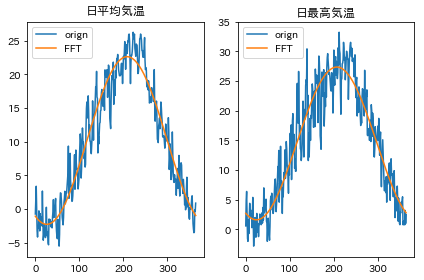

In [6]:
import numpy as np
import matplotlib.pyplot as plt
#日平均気温のプロット
plt.subplot(1,2,1)
x=np.arange(T)
av_y1=fft_av
av_y2=daily_av
plt.title(r"日平均気温")
plt.plot(x,av_y2,label="orign")
plt.plot(x,av_y1,label="FFT")
plt.legend()
#日最高気温のプロット
plt.subplot(1,2,2)
#x=np.arange(365)
max_y1=fft_max
max_y2=daily_max['気温']
plt.title(r"日最高気温")
plt.plot(x,max_y2,label="orign")
plt.plot(x,max_y1,label="FFT")

plt.tight_layout()
plt.legend()
plt.show()

# 通日計算関数

In [7]:
#通日を計算するモジュール
def Nday(Mo,Day):
    import datetime
    NewYear = datetime.datetime(2017,1,1)
    ThatDay = datetime.datetime(2017,Mo,Day)
    Ndays = ThatDay - NewYear
    return Ndays.days + 1

# ⑤⑥FFT日平均気温、FFT日最高気温から暖冷房のフラグを設定する

In [8]:
#フーリエ変換後の外気温度からデフォルトの暖冷房期間を設定する
#フーリエ変換後の日平均気温が15℃以下なら暖房期間
heating_period=[ta['気温'] <= 15. for ta in fft_av ]
#フーリエ変換後の日最高気温が24℃以上なら冷房期間
cooling_period=[ta['気温'] >= 24. for ta in fft_max ]
#print(heating_period[0])

# ⑦暖冷房の開始日、終了日を設定する

In [9]:
#暖冷房の開始日・終了日の計算
prevHeat=heating_period[0]
prevCool=cooling_period[0]
#print(prevHeat,prevCool)
endCooling=0
startCooling=0
endHeating=0
startHeating=0
for i in range(365):
    if prevCool==True and cooling_period[i]==False:
        #冷房終了日
        endCooling=i-1
    elif prevCool==False and cooling_period[i]==True:
        #冷房開始日
        startCooling=i
        
    if prevHeat==True and heating_period[i]==False:
        #暖房終了日
        endHeating=i-1
    elif prevHeat==False and heating_period[i]==True:
        #暖房開始日
        startHeating=i
    prevCool=cooling_period[i]
    prevHeat=heating_period[i]
print('冷房開始日='+str(startCooling))
print('冷房終了日='+str(endCooling))
print('暖房開始日='+str(startHeating))
print('暖房終了日='+str(endHeating))

冷房開始日=164
冷房終了日=249
暖房開始日=277
暖房終了日=140


In [10]:
print(heating_period)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [11]:
print(cooling_period)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

# （１）暖房期間を微調整する

In [12]:
#(1-1) 6/1の暖房フラグがTrueの場合
#raw日平均気温が6/1以降で15℃以上になった翌日から冷房開始日までの暖房フラグをFalseとする
Nday0601 = Nday(6,1) - 1
if heating_period[Nday0601] == True:
    for i in range(Nday0601,365):
        if daily_av['気温'].iloc[i] >= 15 :
            for j in range(i+1,startCooling):
                heating_period[j] = False
            break
            
#print('処理(1-1)')
print(heating_period)

#(1-2) 7/1の暖房フラグがTrueの場合
#7/1から冷房開始日前日までの暖房フラグをFalseとする
Nday0701 = Nday(7,1) - 1
if heating_period[Nday0701] == True:
    for i in range(Nday0701,startCooling):
        heating_period[j] = False

#print('処理(1-2)')
print(heating_period)

#(1-3) 9/30の暖房フラグがTrueの場合
#冷房終了日翌日から、9/30よりさかのぼってraw日平均気温が15℃以上となる前日までの暖房フラグをFalseとする
Nday0930 = Nday(9,30) - 1
if heating_period[Nday0930] == True :
    for i in reversed(range(0,Nday0930+1)):
        if daily_av['気温'].iloc[i] >= 15:
            for j in range(endCooling+1,i+1):
                heating_period[j] = False
            break
            
#print('処理(1-3)')
print(heating_period)
            
#(1-4) 9/15の暖房フラグがTrueの場合
#9/14から冷房期終了翌日までの暖房フラグをFalseとする
Nday0915 = Nday(9,15) - 1
if heating_period[Nday0915] == True:
    for i in range(endCooling+1,Nday0915 - 1):
        heating_period[j] = False
        
#print('処理(1-4)')
print(heating_period)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

# （２）冷房期間を調整する

In [13]:
#(2-1) 7/10の冷房フラグがTrueの場合
#raw日最高気温が7/10以降で最初に23℃以上になった翌日から冷房終了日までの冷房フラグをTrueとする
Nday0710 = Nday(7,10) - 1
if cooling_period[Nday0710] == True:
    for i in range(Nday0710,365):
        if daily_max['気温'].iloc[i] >= 23 :
            for j in range(i+1,endCooling):
                cooling_period[j] = True
            break
            
#print('処理(2-1)')
print(cooling_period)

#（2-2）7/20の冷房フラグ、暖房フラグが共にFalseの場合
#7/20から冷房終了日までの冷房フラグをTrueとする
Nday0720 = Nday(7,20) - 1
if cooling_period[Nday0720] == False and heating_period[Nday0720] == False:
    for i in range(Nday0720,endCooling+1):
        cooling_period[j] = True
            
#print('処理(2-2)')
print(cooling_period)

#（2-3）8/31の冷房フラグ、暖房フラグが共にFalseの場合
#8/31よりさかのぼってraw日最高気温が23℃以上となる日から冷房開始日までの冷房フラグをTrueとする
Nday0831 = Nday(8,31) - 1
#print(Nday0831)
if cooling_period[Nday0831] == False and heating_period[Nday0831] == False :
    #print('8/31は中間期')
    for i in reversed(range(0,Nday0831)):
        #print(daily_max['気温'].iloc[i])
        if daily_max['気温'].iloc[i] >= 23:
            #print('日最高気温が23℃以上となるのは'+str(i))
            for j in reversed(range(startCooling,i+1)):
                cooling_period[j] = True
            break
            
#print('処理(2-3)')
print(cooling_period)
            
#（2-4）8/15の冷房フラグ、暖房フラグが共にFalseの場合
#冷房開始日から8/14までの冷房フラグをTrueとする
Nday0815 = Nday(8,15) - 1
if cooling_period[Nday0815] == False and heating_period[Nday0815] == False:
    for i in range(startCool,Nday0815+1):
        cooling_period[j] = True
        
#print('処理(2-4)')
print(cooling_period)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False